# Aim of this document is to create a model of the FWt with Gravity acting as an external force and linerise the EoM about all ifxed points (across velocities)

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [58]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)
p.g.value = 9.81*0.5

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system

In [59]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [0,2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(x):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)    
    guess = [np.pi/2,0]
    for v in vs:
        p.V.value = v
        guess = minimize(ToMinimise,guess).x
        df = df.append({'aoa' : i, 'v' : v,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

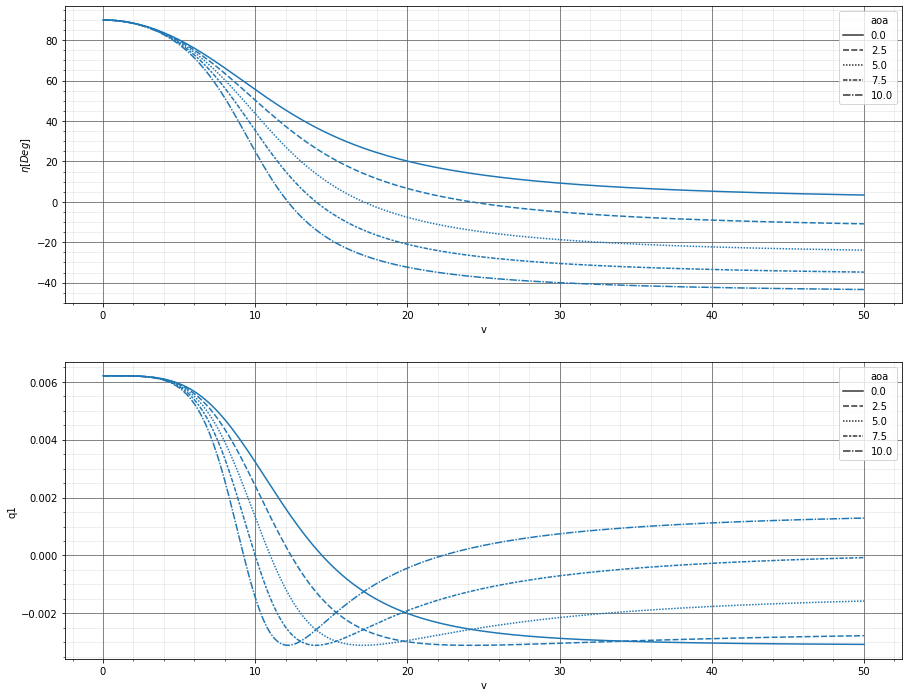

In [60]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='aoa',ax=axes[0])

sns.lineplot(data=df,y='q1',x='v',style='aoa',ax=axes[1])

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [61]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.alpha_r])

In [62]:
dat = df

flutdfv2 = pd.DataFrame()
for a in dat['aoa'].unique():
    #get relevent data points
    data = dat[dat['aoa']==a]
    
    for i in range(0,len(data)):  
        # get the fixed point
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],np.deg2rad(a),lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = data['v'].iloc[i]
        jac_dat['aoa'] = a
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,V,aoa,lp
0,0,0.000000+2.712471j,0.000000e+00,2.712471,0.431703,6.123234e-17,True,0.00,0.0,"[1.570796326785037, 0, 0.006212247849942992, 0]"
1,1,0.000000+12.566371j,0.000000e+00,12.566371,2.000000,6.123234e-17,True,0.00,0.0,"[1.570796326785037, 0, 0.006212247849942992, 0]"
2,0,-0.018040+2.712429j,-1.803961e-02,2.712429,0.431706,-6.650576e-03,True,0.25,0.0,"[1.5703619493517182, 0, 0.006212245869046912, 0]"
3,1,-0.000000+12.566371j,-4.809571e-10,12.566371,2.000000,-3.827332e-11,True,0.25,0.0,"[1.5703619493517182, 0, 0.006212245869046912, 0]"
4,0,-0.036079+2.712305j,-3.607923e-02,2.712305,0.431715,-1.330088e-02,True,0.50,0.0,"[1.5690587897025425, 0, 0.006212221057117892, 0]"
...,...,...,...,...,...,...,...,...,...,...
2005,1,0.697214+12.605791j,6.972143e-01,12.605791,2.009340,5.522464e-02,False,49.50,10.0,"[-0.7568268422969548, 0, 0.0012869625713239265..."
2006,0,-4.602894+12.644758j,-4.602894e+00,12.644758,2.141663,-3.420581e-01,False,49.75,10.0,"[-0.7571481949129072, 0, 0.0012899517001375995..."
2007,1,0.704088+12.615553j,7.040883e-01,12.615553,2.010952,5.572441e-02,False,49.75,10.0,"[-0.7571481949129072, 0, 0.0012899517001375995..."
2008,0,-4.628895+12.697470j,-4.628895e+00,12.697470,2.150963,-3.425032e-01,False,50.00,10.0,"[-0.7574645486118318, 0, 0.0012928944356024622..."


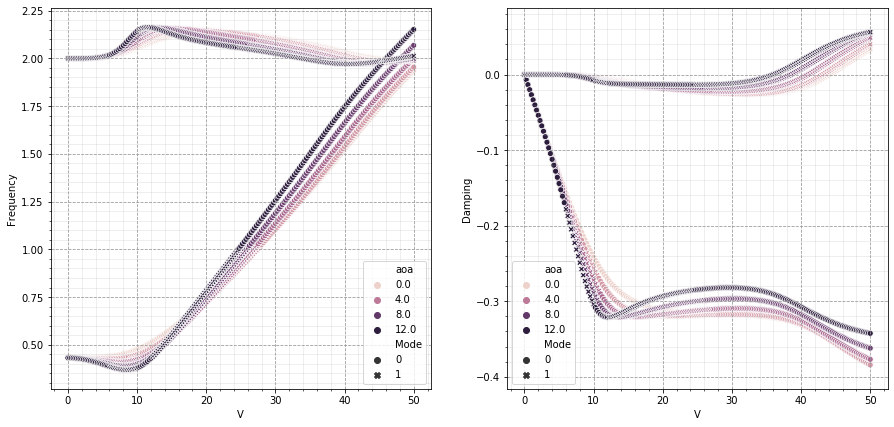

In [65]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [64]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[~flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
354,0.0,44.25,4.287307
748,2.5,43.25,-9.799765
1134,5.0,41.25,-22.585771
1516,7.5,38.75,-33.237513
1898,10.0,36.25,-41.732230
